# MCMC4.0: Replica Exchange Monte Carlo (Parallel Tempering)

In order to get correct and unbiased results from QMC simulations, we need to implement a "global updating" algorithm in addition to the single-flip "local updating." There are two major ways to do parallelization in Julia, Channels and MPI.jl. Here I try to rewrite the previous code using Channels to implement parallelization to show how it goes in Jupyter Notebook. However, in most cases MPI.jl is faster. The implementation based on MPI.jl will be included in [mcmc4.5.jl](./mcmc4.5.jl).

## Autocorrelation revisited

It was already found (especially in MCMC3.5) that the autocorrelation length is a key feature determining the efficiency of MCMC. StatsBase.jl includes methods for the autocorrelation.

In [1]:
using StatsBase

In order to decrease the autocorrelation length, we basically need to increase the acceptance rate.

In the case of continuous variables, the acceptance rate can be increased by using a Gibbs sampler (100%) or a hybrid Monte Carlo (almost 100%). You can easily check the autocorrelation of the Gibbs sampler.

In [2]:
using Plots; gr()

Plots.GRBackend()

We use the same Gibbs sampler as before.

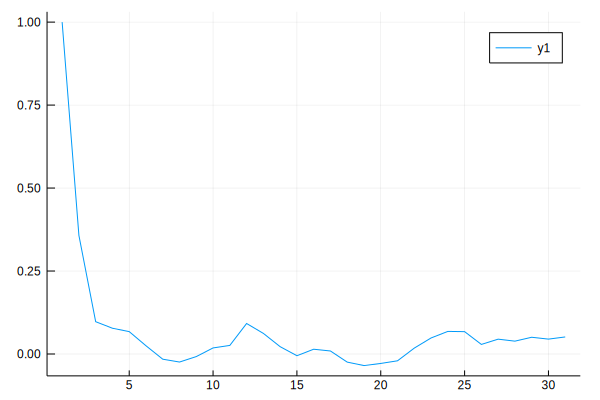

In [4]:
using Distributions
using ResumableFunctions
function Gibbssampler(a::Float64, b::Float64, c::Float64, x::Float64, y::Float64)::Tuple{Float64, Float64}
    x = rand(Normal(b / a * y, 1 / sqrt(a)))
    y = rand(Normal(b / c * x, 1 / sqrt(c)))
    x, y
end
@resumable function sampling(a::Float64, b::Float64, c::Float64)::Tuple{Float64, Float64}
    x = 0.0
    y = 0.0
    while true
        x, y = Gibbssampler(a, b, c, x, y)
        @yield x, y
    end
end
mcstep = sampling(1.0, 0.6, 1.0)
samples = collect(Iterators.take(Iterators.drop(mcstep, 1000), 1000))
plot(StatsBase.autocor(first.(samples)))

The autocorrelation length is already small in this algorithm.

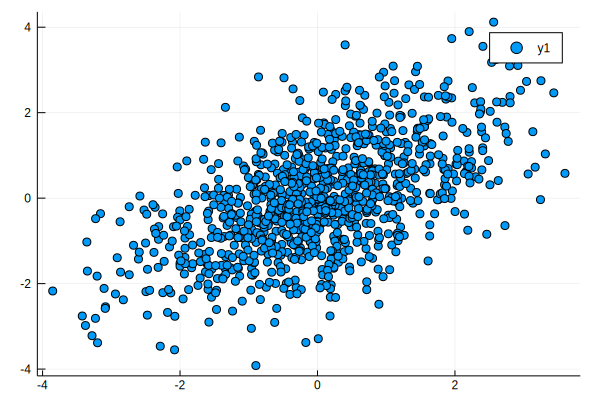

In [5]:
scatter(first.(samples), last.(samples))

Looks nice. However, those algorithms usually do not work for discrete variables, which are important for physical applications. Another way to reduce the autocorrelation length is by implementing global updating. There are various technologies for global updating, but replica exchange is the most universal (in the same way as Metropolis-Hastings was universally applicable to any probabilistic distributions).

## Replica exchange

Replica exchange Monte Carlo (parallel tempering) is one of the most typical extended ensemble methods. Physically local updating methods (e.g. single flip) will be stuck in the "local minimum" at low temperature or at some critical point, so we need a global updating like "tempering" to escape from the local minimum. However, just simple tempering does not necessarily produce the correct distribution, so we use an extended ensemble to correct the behavior.

In [6]:
using Distributed
addprocs(2)
nworkers()

2

This enables us to do parallel computing with 2 working processes. Here let's use a very simple thread parallelization for this problem. Later I will try to use a process parallelization, which is more suitable.

In [7]:
b = [0.3, 0.6]
@everywhere function simpleMetropolis(Δlogp::Float64)::Bool
    Δlogp > log(1.0 - rand())
end
@everywhere using Distributions
@everywhere function Gibbs(b::Float64, xy::Vector{Float64})::Vector{Float64} # somehow Tuple does not work (why?)
    # it is better to repeat this Gibbs sampler in reality
    xy[1] = rand(Normal(b * xy[2], 1.0))
    xy[2] = rand(Normal(b * xy[1], 1.0))
    xy
end
@resumable function replica2(b::Vector{Float64})::Vector{Vector{Float64}}
    xy = [zeros(Float64, 2), zeros(Float64, 2)] # it is not good to use the same name for a scalar and an array
    while true
        if simpleMetropolis(sum(b .* reverse(prod.(xy))) - sum(b .* prod.(xy)))
            xy[1], xy[2] = xy[2], xy[1] # .= does not work
        end
        xy = pmap(Gibbs, b, xy)
        @yield xy
    end
end
mcstep = replica2(b)
iter = Iterators.take(Iterators.drop(mcstep, 1000), 1000)

Base.Iterators.Take{Base.Iterators.Drop{getfield(Main, Symbol("##368"))}}(Base.Iterators.Drop{getfield(Main, Symbol("##368"))}(getfield(Main, Symbol("##368"))(0x00, [0.3, 0.6], #undef), 1000), 1000)

`pmap` is a parallel version of a higher-order function, `map`.

In [8]:
data = collect(iter)

1000-element Array{Array{Array{Float64,1},1},1}:
 [[1.54026, 1.06803], [-1.53363, -1.03507]]      
 [[-1.76378, -0.484532], [-2.66449, -1.69561]]   
 [[-2.73883, -2.26691], [-1.82539, -1.5171]]     
 [[0.260982, 0.320865], [-3.20527, -2.10116]]    
 [[-0.200618, -0.259338], [-1.07167, -1.45124]]  
 [[-0.304298, -1.45266], [0.351168, -0.0677171]] 
 [[-0.0415442, 0.128899], [-1.80648, -1.85733]]  
 [[-0.927598, -1.24852], [0.624608, 0.498335]]   
 [[2.05642, 0.303677], [0.519838, -0.193219]]    
 [[-0.106196, 1.85632], [-0.284312, -1.73237]]   
 [[0.398023, 2.07432], [1.24326, 0.404324]]      
 [[2.16404, 0.752687], [-0.257835, -0.204911]]   
 [[-1.01861, 0.49402], [1.88868, -0.782851]]     
 ⋮                                               
 [[-1.00479, -0.174982], [-1.12067, -1.08284]]   
 [[0.612651, 0.582564], [-2.1545, -2.41922]]     
 [[-0.830073, -0.686035], [-0.904871, -0.383553]]
 [[-0.194362, 0.281162], [1.43006, 2.03865]]     
 [[0.183781, 0.236391], [1.0699, 1.29495]]       
 

Now we can get two distributions simultaneously.

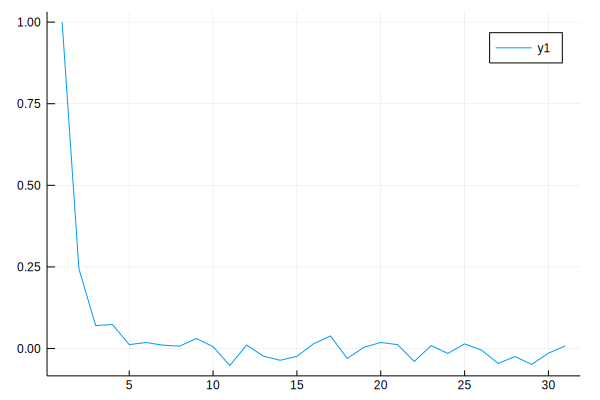

In [9]:
second = last.(data)
plot(StatsBase.autocor(last.(second)))

Now the autocorrelation length is reduced again.

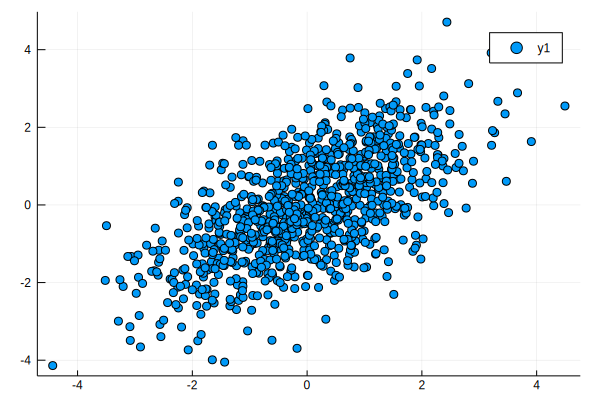

In [10]:
scatter(first.(second), last.(second))

Do you agree that this scatter plot is better than before?

Last but not least, we forgot mentioning that we can simply increase the acceptance rate by changing the proposed distribution of Metropolis-Hastings. This point will be discussed in MCMC6.5.

## Kitaev model revisited

There are two ways to exchange the distributions, one by exchanging the temperature, the other by exchanging the internal states. Apparently, the former is faster, but in the case of the Kitaev model the latter is still acceptable because the internal state is just labelled by the flux sector and not memory-consumptive. I will implement by exchaging the states. *There is another reason for this decision, which you will see later.* First, let me rewrite the previous code by `BitVector`.

In [11]:
@everywhere using SparseArrays
@everywhere using LinearAlgebra
@everywhere const Jx = 1 / 3 # oppposite sign to Motome's
@everywhere const Jy = 1 / 3
@everywhere const Jz = 1 / 3
@everywhere function Metropolis(βF::Float64, βFnew::Float64)::Bool
    βF - βFnew > log(1.0 - rand())
end
@everywhere function openhoneycomb(Lx::Int64, Ly::Int64)::Tuple
    N = 2Lx * Ly
    nnx = zip(1 : 2 : (N - 1), 2 : 2 : N)
    nny = Iterators.flatten((zip((1 + 2i) : 2Lx : (2Lx * (Ly - 1)  + 1 + 2i), 2i : 2Lx : (2Lx * (Ly - 1)  + 2i)) for i in 1 : (Lx - 1)))
    nnz = zip(1 : 2 : (N - 1), Iterators.flatten(((2Lx + 2) : 2 : N, 2 : 2 : 2Lx)))
    plaquette = Iterators.flatten(zip((Lx * (i - 1) + 1) : (Lx * (i - 1) + Lx - 1), (Lx * (i - 1) + 2) : (Lx * (i - 1) + Lx)) for i in 1 : Ly)
    N, nnx, nny, nnz, plaquette
end
@everywhere function freeenergy(β₂::Float64)::Function
    ϵ -> log(exp(β₂ * ϵ) + exp(-β₂ * ϵ))
end
@everywhere function energy(β₂::Float64)::Function
    ϵ -> ϵ * tanh(β₂ * ϵ)
end
@everywhere function denergy(β₂::Float64)::Function
    ϵ -> (ϵ * sech(β₂ * ϵ)) ^ 2
end
@resumable function measurementEf(method::Function, lattice::Function, β::Float64, Lx::Int64, Ly::Int64)::Vector{Float64}
    N, nnx, nny, nnz, plaquette = lattice(Lx, Ly)
    iter = Iterators.flatten((Iterators.product(J, nn) for (J, nn) in [(Jx, nnx), (Jy, nny), (Jz, nnz)]))
    h = spzeros(Complex{Float64}, N, N)
    for (J, nn) in iter
        h[nn[1], nn[2]] = 2.0im * J
        h[nn[2], nn[1]] = -2.0im * J
    end
    NNz = collect(nnz)
    Nz = length(NNz)
    η = trues(Nz)
    βF = 0.0
    β₂ = β * 0.5
    hdense = Array(h)
    posev = zeros(Float64, N >> 1)
    while true
        for i in 1 : Nz
            j = rand(1 : Nz)
            hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
            hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
            evnew = eigvals(Hermitian(hdense))
            iter = Iterators.drop(evnew, N >> 1)
            βFnew = -sum(freeenergy(β₂), iter) # super-memory-efficient code
            if method(βF, βFnew)
                η[j] = !η[j]
                βF = βFnew
                posev = collect(iter)
            else
                hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
                hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
            end
        end
        Ef = -0.5 * sum(energy(β₂), posev)
        ∂Ef∂β = -0.25 * sum(denergy(β₂), posev)
        @yield [Ef, ∂Ef∂β]
    end
end

measurementEf (generic function with 1 method)

In [13]:
β = 100.0
mcstep2 = Iterators.drop(measurementEf(Metropolis, openhoneycomb, β, 4, 4), 2000)
iter2 = Iterators.take(mcstep2, 10)
data2 = collect(iter2)

10-element Array{Array{Float64,1},1}:
 [-7.88834, -1.57383e-16]
 [-7.88834, -1.57383e-16]
 [-7.92006, -1.75306e-21]
 [-7.92006, -1.75306e-21]
 [-7.92006, -1.75306e-21]
 [-7.92006, -1.75306e-21]
 [-7.88834, -1.57383e-16]
 [-7.92006, -1.75306e-21]
 [-7.92006, -1.75306e-21]
 [-7.92006, -1.75306e-21]

Then, let's rewrite the code by Channels!

In [14]:
function measurementChannel(method::Function, lattice::Function, β::Float64, Lx::Int64, Ly::Int64)::Channel
    Channel(ctype = Vector{Float64}) do channel::Channel{Vector{Float64}}
        N, nnx, nny, nnz, plaquette = lattice(Lx, Ly)
        iter = Iterators.flatten((Iterators.product(J, nn) for (J, nn) in [(Jx, nnx), (Jy, nny), (Jz, nnz)]))
        h = spzeros(Complex{Float64}, N, N)
        for (J, nn) in iter
            h[nn[1], nn[2]] = 2.0im * J
            h[nn[2], nn[1]] = -2.0im * J
        end
        NNz = collect(nnz)
        Nz = length(NNz)
        η = trues(Nz)
        βF = 0.0
        β₂ = β * 0.5
        hdense = Array(h)
        posev = zeros(Float64, N >> 1)
        while true
            for i in 1 : Nz
                j = rand(1 : Nz)
                hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
                hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
                evnew = eigvals(Hermitian(hdense))
                iter = Iterators.drop(evnew, N >> 1)
                βFnew = -sum(freeenergy(β₂), iter)
                if method(βF, βFnew)
                    η[j] = !η[j]
                    βF = βFnew
                    posev = collect(iter)
                else
                    hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
                    hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
                end
            end
            Ef = -0.5 * sum(energy(β₂), posev)
            ∂Ef∂β = -0.25 * sum(denergy(β₂), posev)
            put!(channel, [Ef, ∂Ef∂β])
        end
    end
end

measurementChannel (generic function with 1 method)

In [15]:
@everywhere using Statistics
@everywhere function leaveoneout(before::Function, after::Function, v::AbstractVector)
    ind = eachindex(v)
    map(i -> after(mean(map(before, view(v, filter(!isequal(i), ind))))), ind)
end
@everywhere meanJ(b::Function, a::Function, v::AbstractVector) = mean(leaveoneout(b, a, v))
@everywhere stdmJ(b::Function, a::Function, v::AbstractVector, m) = stdm(leaveoneout(b, a, v), m, corrected = false) * sqrt(length(v) - 1)
@everywhere TTCv(v::Vector{Float64}) = [v[1] ^ 2 - v[2], v[1]]
@everywhere function Cv(β::Float64)::Function
    β² = β ^ 2
    meanTTCv::Vector{Float64} -> β² * (meanTTCv[1] - meanTTCv[2] ^ 2)
end
mcstep3 = Iterators.drop(measurementChannel(Metropolis, openhoneycomb, β, 4, 4), 2000)
iter3 = Iterators.take(mcstep3, 10000)
data3 = collect(iter3)
m3 = meanJ(TTCv, Cv(β), data3)
s3 = stdmJ(TTCv, Cv(β), data3, m3)
println("Cv (incorrect) = $m3 ± $s3")

Cv (incorrect) = 4.611941062561039 ± 0.10547527079900641


It is amazing to see that for this Monte Carlo code, `Channel` is faster than `ResumableFunctions`. However, unfortunately, `Chennel` itself is not distributed over processes but works serially (currently in Julia 1.0). In order to make it parallel, we need to use `RemoteChannel` instead.

In [16]:
@everywhere function measurement(n::Int64, exchange1::RemoteChannel, exchange2::RemoteChannel,
        reduction::RemoteChannel, isaccepted::RemoteChannel,
        method::Function, lattice::Function, β::Float64, Lx::Int64, Ly::Int64)::Channel
    Channel(ctype = Vector{Float64}) do channel::Channel{Vector{Float64}}
        N, nnx, nny, nnz, plaquette = lattice(Lx, Ly)
        iter = Iterators.flatten((Iterators.product(J, nn) for (J, nn) in [(Jx, nnx), (Jy, nny), (Jz, nnz)]))
        h = spzeros(Complex{Float64}, N, N)
        for (J, nn) in iter
            h[nn[1], nn[2]] = 2.0im * J
            h[nn[2], nn[1]] = -2.0im * J
        end
        NNz = collect(nnz)
        Nz = length(NNz)
        η = trues(Nz)
        ηnew = similar(η)
        βF = 0.0
        β₂ = β * 0.5
        hdense = Array(h)
        posev = zeros(Float64, N >> 1)
        while true
            if n == 1
                put!(exchange2, η)
                ηnew = take!(exchange1)
            elseif n == 2
                ηnew = take!(exchange2)
                put!(exchange1, η)
            end
            for (j, bool) in enumerate(ηnew)
                x = bool ? 1.0 : -1.0
                h[NNz[j][1], NNz[j][2]] = 2.0im * Jz * x
                h[NNz[j][2], NNz[j][1]] = -2.0im * Jz * x
            end
            evnew = eigvals(Hermitian(Array(h)))
            iter = Iterators.drop(evnew, N >> 1)
            βFnew = -sum(freeenergy(β₂), iter)
            if n == 1
                put!(reduction, βF - βFnew)
                if take!(isaccepted)
                    η .= ηnew
                    βF = βFnew
                    posev = collect(iter)
                    hdense = Array(h)
                end
            elseif n == 2
                diff = take!(reduction)
                if simpleMetropolis(βF - βFnew + diff) # only accept Metropolis
                    put!(isaccepted, true)
                    η .= ηnew
                    βF = βFnew
                    posev = collect(iter)
                    hdense = Array(h)
                else
                    put!(isaccepted, false)
                end
            end

            for i in 1 : Nz
                j = rand(1 : Nz)
                hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
                hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
                evnew = eigvals(Hermitian(hdense))
                iter = Iterators.drop(evnew, N >> 1)
                βFnew = -sum(freeenergy(β₂), iter)
                if method(βF, βFnew)
                    η[j] = !η[j]
                    βF = βFnew
                    posev = collect(iter)
                else
                    hdense[NNz[j][1], NNz[j][2]] = -hdense[NNz[j][1], NNz[j][2]]
                    hdense[NNz[j][2], NNz[j][1]] = -hdense[NNz[j][2], NNz[j][1]]
                end
            end
            Ef = -0.5 * sum(energy(β₂), posev)
            ∂Ef∂β = -0.25 * sum(denergy(β₂), posev)
            put!(channel, [Ef, ∂Ef∂β])
        end
    end
end
@everywhere function replica(input::RemoteChannel, exchange1::RemoteChannel, exchange2::RemoteChannel,
        reduction::RemoteChannel, isaccepted::RemoteChannel, result::RemoteChannel,
        method::Function, lattice::Function, Lx::Int64, Ly::Int64)
    n, β = take!(input)
    mcstep = Iterators.drop(measurement(n, exchange1, exchange2, reduction, isaccepted, method, lattice, β, Lx, Ly), 2000)
    iter = Iterators.take(mcstep, 10000)
    data = collect(iter)
    # measurements should be done inside each process
    m = meanJ(TTCv, Cv(β), data)
    s = stdmJ(TTCv, Cv(β), data, m)
    put!(result, (n, β, m, s))
end
function initialize(method::Function, lattice::Function, βs::Vector{Float64}, Lx::Int64, Ly::Int64)
    temp = RemoteChannel(()->Channel{Tuple}(32))
    exchange1 = RemoteChannel(()->Channel{BitVector}(32)) # This is not a smart way...
    exchange2 = RemoteChannel(()->Channel{BitVector}(32))
    reduction = RemoteChannel(()->Channel{Float64}(32))
    isaccepted = RemoteChannel(()->Channel{Bool}(32))
    resultCv = RemoteChannel(()->Channel{Tuple}(32))
    n = length(βs)
    @async for x in enumerate(βs)
        put!(temp, x)
    end
    for p in workers() # the number of workers must be two
        remote_do(replica, p, temp, exchange1, exchange2, reduction, isaccepted, resultCv, method, lattice, Lx, Ly)
    end
    while n > 0
        x = take!(resultCv)
        println(x)
        n -= 1
    end
end
initialize(Metropolis, openhoneycomb, [50.0, 100.0], 4, 4)

(1, 50.0, 4.829123629095059, 0.06541250551780155)
(2, 100.0, 4.749486410538502, 0.10429937595643976)


`RemoteChannel` is not iterable, so partially I used `Channel` to sample from each distribution. This is why I exchanged the states instead of the temperatures. Processes are interacting via `RemoteChannel` and sampling is done inside each process using `Channel`. If you calculate the acceptance rate, you easily see that at low temperature the state is updated mostly by the replica exchange.

## MPI.jl

The same thing is implemented by MPI.jl in mcmc4.5.jl. You need to execute it from the terminal by
```
mpiexec -np 2 julia mcmc4.5.jl
```

## RemoteChannel revisited

In this implementation, `RemoteChannel` and MPI.jl share almost the same algorithm and the difference is not clear, so I will present a more Julia-like code using characteristic functionality of `RemoteChannel`.

~ under construction ~

**Exercise**: implement scheduling for large-scale parallelization.